In [5]:
import pandas as pd
import numpy as np
import re
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt

def find_root():
    current = Path.cwd().resolve()
    for path in [current] + list(current.parents):
        if (path / "data").exists():
            return path
    return current

PROJECT_ROOT = find_root()
RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Reading Raw Data from: {RAW_DIR}")
print(f"Saving Processed Data to: {PROCESSED_DIR}")

Project Root: C:\Users\gefer\OneDrive - Univerzita Karlova\Natural Gas python\Final Project\Python-Final-Project-Natural-gas-price-analysis-
Reading Raw Data from: C:\Users\gefer\OneDrive - Univerzita Karlova\Natural Gas python\Final Project\Python-Final-Project-Natural-gas-price-analysis-\data\raw
Saving Processed Data to: C:\Users\gefer\OneDrive - Univerzita Karlova\Natural Gas python\Final Project\Python-Final-Project-Natural-gas-price-analysis-\data\processed


In [6]:
raw_data_path = RAW_DIR / "henry_hub_weekly.csv"
df = pd.read_csv(raw_data_path)

df.columns = [col.strip().lower() for col in df.columns]
df = df.dropna(subset=["week_of"]).copy()
df["week_of"] = df["week_of"].astype(str).str.strip()

print(f"Dataset Shape: {df.shape}")
display(df.head())

Dataset Shape: (1512, 6)


,week_of,mon,tue,wed,thu,fri
0,1997 Jan- 6 to Jan-10,NaN,3.82,3.80,3.61,3.92
1,1997 Jan-13 to Jan-17,4.00,4.01,4.34,4.71,3.91
2,1997 Jan-20 to Jan-24,3.26,2.99,3.05,2.96,2.62
3,1997 Jan-27 to Jan-31,2.98,3.05,2.91,2.86,2.77
4,1997 Feb- 3 to Feb- 7,2.49,2.59,2.65,2.51,2.39


In [7]:
def parse_week_start(s: str):
    """
    Parses '1997 Jan- 6 to Jan-10' robustly using Regex.
    """
    s = str(s)
    
    m_year = re.search(r"(\d{4})", s)
    if not m_year: return pd.NaT
    year = int(m_year.group(1))

    m_mon = re.search(r"\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b", s)
    if not m_mon: return pd.NaT
    mon = m_mon.group(1)

    m_day = re.search(rf"{mon}\s*-\s*(\d{{1,2}})", s)
    if not m_day: return pd.NaT
    day = int(m_day.group(1))

    return pd.to_datetime(f"{year} {mon} {day}", format="%Y %b %d", errors="coerce")

df["week_start"] = df["week_of"].apply(parse_week_start)

for c in ["mon", "tue", "wed", "thu", "fri"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("Missing week_start dates:", df["week_start"].isna().sum())
display(df.head())

Missing week_start dates: 0


,week_of,mon,tue,wed,thu,fri,week_start
0,1997 Jan- 6 to Jan-10,NaN,3.82,3.80,3.61,3.92,1997-01-06
1,1997 Jan-13 to Jan-17,4.00,4.01,4.34,4.71,3.91,1997-01-13
2,1997 Jan-20 to Jan-24,3.26,2.99,3.05,2.96,2.62,1997-01-20
3,1997 Jan-27 to Jan-31,2.98,3.05,2.91,2.86,2.77,1997-01-27
4,1997 Feb- 3 to Feb- 7,2.49,2.59,2.65,2.51,2.39,1997-02-03


Saved Daily Prices (7278 rows) to henryhub_daily.csv
Saved Weekly Returns (1511 rows) to henryhub_weekly_returns.csv


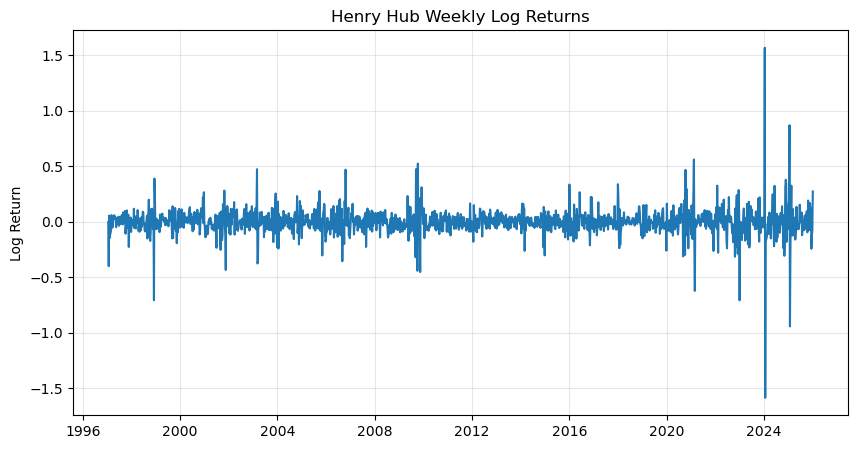

In [9]:
daily = df.melt(
    id_vars=["week_of", "week_start"],
    value_vars=["mon", "tue", "wed", "thu", "fri"],
    var_name="dow",
    value_name="price_usd_per_mmbtu"
)

dow_to_offset = {"mon": 0, "tue": 1, "wed": 2, "thu": 3, "fri": 4}
daily["date"] = daily["week_start"] + pd.to_timedelta(daily["dow"].map(dow_to_offset), unit="D")

daily = daily.dropna(subset=["date", "price_usd_per_mmbtu"]).sort_values("date")
daily = daily[["date", "price_usd_per_mmbtu"]].reset_index(drop=True)

daily.to_csv(PROCESSED_DIR / "henryhub_daily.csv", index=False)
print(f"Saved Daily Prices ({len(daily)} rows) to henryhub_daily.csv")


weekly = (
    daily
    .sort_values("date")
    .groupby(pd.Grouper(key="date", freq="W-FRI"))
    .agg(price=("price_usd_per_mmbtu", "last"))
    .dropna()
    .reset_index()
)

weekly["log_return"] = np.log(weekly["price"]).diff()
weekly = weekly.dropna().reset_index(drop=True)

weekly['YYYYMM'] = weekly['date'].dt.year * 100 + weekly['date'].dt.month

weekly.to_csv(PROCESSED_DIR / "henryhub_weekly_returns.csv", index=False)
print(f"Saved Weekly Returns ({len(weekly)} rows) to henryhub_weekly_returns.csv")

plt.figure(figsize=(10,5))
plt.plot(weekly["date"], weekly["log_return"])
plt.title("Henry Hub Weekly Log Returns")
plt.ylabel("Log Return")
plt.grid(True, alpha=0.3)
plt.show()